In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

SEED=1
cpu=6
datasetFolder=os.path.dirname(os.path.dirname(os.getcwd()))


def predict_score(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    best_pipe=model.best_estimator_
    poly=best_pipe.named_steps["polynomial_features"]
    poly_features=poly.get_feature_names_out(list(x_train.columns))
    selector=best_pipe.named_steps["feature_selection"]
    select_indices=selector.get_support(1)
    select_features=poly_features[select_indices]
    y_predict=model.predict(x_test)
    f1=f1_score(y_test,y_predict)
    auc_score=roc_auc_score(y_test,y_predict)
    return f1,auc_score,select_features
    
def baseDataSet(x_train,x_test):
    new_x_train=x_train[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x']]
    new_x_test=x_test[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x']]

    return new_x_train,new_x_test

def addMetricsDataSet(x_train,x_test):
    new_x_train=x_train[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x', 'FDP_x']]
    new_x_test=x_test[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x', 'FDP_x']]
    return new_x_train,new_x_test

def addOldVersionDataSet(FeatureEnvyFile):
    df=pd.read_csv(FeatureEnvyFile,encoding_errors="replace")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x', 'FDP_x', 'fanin_y', 'fanout_y', 'wmc_y', 'loc_y', 'returnsQty_y', 'variablesQty_y', 'parametersQty_y', 'loopQty_y', 'anonymousClassesQty_y', 'innerClassesQty_y', 'ATFD_y', 'ATLD_y', 'LAA_y', 'FDP_y', 'FeatureEnvy']]
    df=df.dropna(how="any")
    return df

def overSampling(x_train,y_train):
    x_sampling,y_sampling=SMOTE(sampling_strategy=0.2,random_state=SEED).fit_resample(x_train,y_train)
    return x_sampling,y_sampling


In [ ]:
FeatureEnvyFile=os.path.join(datasetFolder,"dataset2\\FeatureEnvy.csv")
df=pd.read_csv(FeatureEnvyFile,encoding_errors="replace")
x=df.drop(columns=["file","class","method","qualifiedName","FeatureEnvy"])
y=df[["FeatureEnvy"]].values.ravel()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=SEED)
x_train_sampling,y_train_sampling=overSampling(x_train,y_train)
#x_train_base,y_train_base,x_test_base,y_test_base,features_base=create_train_test_data(x_base,y_base)

x_base_sampling,x_base_test=baseDataSet(x_train_sampling,x_test)
y_base_sampling=y_train_sampling
y_base_test=y_test

x_add_sampling,x_add_test=addMetricsDataSet(x_train_sampling,x_test)
y_add_sampling=y_train_sampling
y_add_test=y_test


In [ ]:
name="RF"
RF_prameter={    
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
    }

k_range=np.arange(1,11,1)
f1_baselist=[]
auc_baselist=[]
features_baselist=[]
f1_addlist=[]
auc_addlist=[]
features_addlist=[]
for i in k_range:
    pipline=Pipeline([
        ('polynomial_features', PolynomialFeatures(degree=2)),
        ('minmaxscaler', MinMaxScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ])
    RF_model=RandomizedSearchCV(pipline,param_distributions=RF_prameter,cv=KFold(n_splits=10,shuffle=True,random_state=SEED),random_state=SEED,n_iter=cpu)
    
    

    print(str(i))
    f1_base,auc_score_base,feature_base=predict_score(RF_model,x_base_sampling,y_base_sampling,x_base_test,y_base_test,name)
    f1_baselist.append(f1_base)
    auc_baselist.append(auc_score_base)
    features_baselist.append(feature_base)
    
    f1_add,auc_score_add,feature_add=predict_score(RF_model,x_add_sampling,y_add_sampling,x_add_test,y_add_test,name)
    f1_addlist.append(f1_add)
    auc_addlist.append(auc_score_add)
    features_addlist.append(feature_add)


1


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

2


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

3


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

4


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

5


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

6


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

7


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

8


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

9


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

10


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

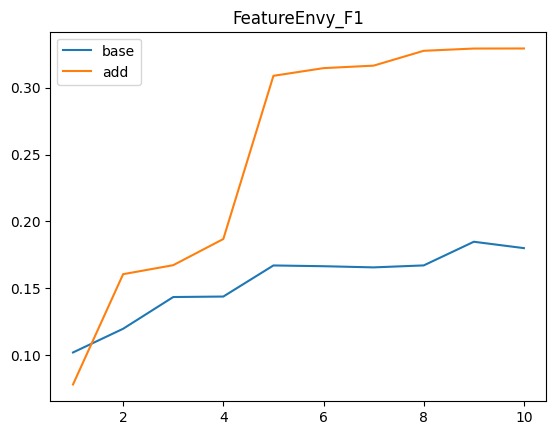

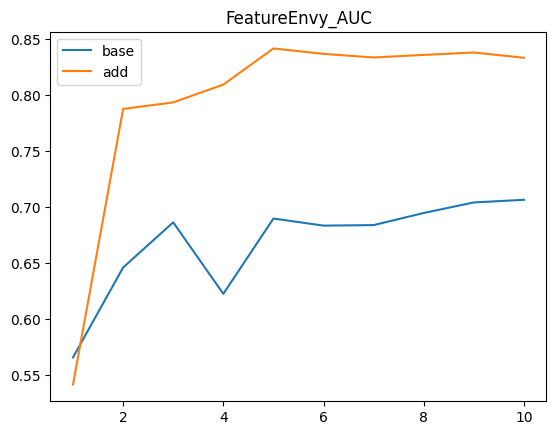

In [8]:
import matplotlib.pyplot as plt

x=k_range
plt.title("FeatureEnvy_F1")
plt.plot(x,f1_baselist,label="base")
plt.plot(x,f1_addlist,label="add")
plt.legend()
plt.show()

plt.title("FeatureEnvy_AUC")
plt.plot(x,auc_baselist,label="base")
plt.plot(x,auc_addlist,label="add")
plt.legend()
plt.show()

In [9]:
print("f1_base : ",f1_baselist)
print("f1_add : ",f1_addlist)
print("auc_base : ",auc_baselist)
print("auc_add : ",auc_addlist)

f1_base :  [0.10224558050645007, 0.11993033092809156, 0.14361445783132532, 0.1439820022497188, 0.167186171720034, 0.1666179479684303, 0.16574905824398725, 0.1672185430463576, 0.18487891317188423, 0.18011894647408666]
f1_add :  [0.07834359261331841, 0.160676532769556, 0.1673913043478261, 0.18692682926829268, 0.30873726458783574, 0.3144774688398849, 0.31633647288080546, 0.32741881486441243, 0.3290969899665552, 0.32914828639294197]
auc_base :  [0.5654566142903009, 0.645863850406262, 0.686263862321186, 0.6222930198421366, 0.6896667381250736, 0.6833444854115094, 0.6838038404975705, 0.6946471088587615, 0.7040846263698336, 0.7064264200775602]
auc_add :  [0.541221537096799, 0.7877797146448374, 0.7935610734038712, 0.809518418080046, 0.8418180720853934, 0.8369727561839675, 0.8337756152052489, 0.8360628810109585, 0.8382242642962611, 0.8335051682279836]


SEED=1
f1_base :  [0.10224558050645007, 0.11993033092809156, 0.14361445783132532, 0.1439820022497188, 0.167186171720034, 0.1666179479684303, 0.16574905824398725, 0.1672185430463576, 0.18487891317188423, 0.18011894647408666]
f1_add :  [0.07834359261331841, 0.160676532769556, 0.1673913043478261, 0.18692682926829268, 0.30873726458783574, 0.3144774688398849, 0.31633647288080546, 0.32741881486441243, 0.3290969899665552, 0.32914828639294197]
auc_base :  [0.5654566142903009, 0.645863850406262, 0.686263862321186, 0.6222930198421366, 0.6896667381250736, 0.6833444854115094, 0.6838038404975705, 0.6946471088587615, 0.7040846263698336, 0.7064264200775602]
auc_add :  [0.541221537096799, 0.7877797146448374, 0.7935610734038712, 0.809518418080046, 0.8418180720853934, 0.8369727561839675, 0.8337756152052489, 0.8360628810109585, 0.8382242642962611, 0.8335051682279836]